In [4]:
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2,DenseNet121
from tensorflow.keras.optimizers import Adam

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
dataset_path = '/content/drive/MyDrive/Cancer_Dataset'

In [10]:
# Define image size
IMG_HEIGHT, IMG_WIDTH = 224, 224  # Resize to 224x224 for CNN

In [11]:
class_names = ['malignant', 'benign', 'normal']
def load_data(dataset_path):
    images = []
    labels = []


    for label, class_name in enumerate(class_names):
        class_path = os.path.join(dataset_path, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))  # Resize image
            images.append(img)
            labels.append(label)

    return np.array(images), np.array(labels)


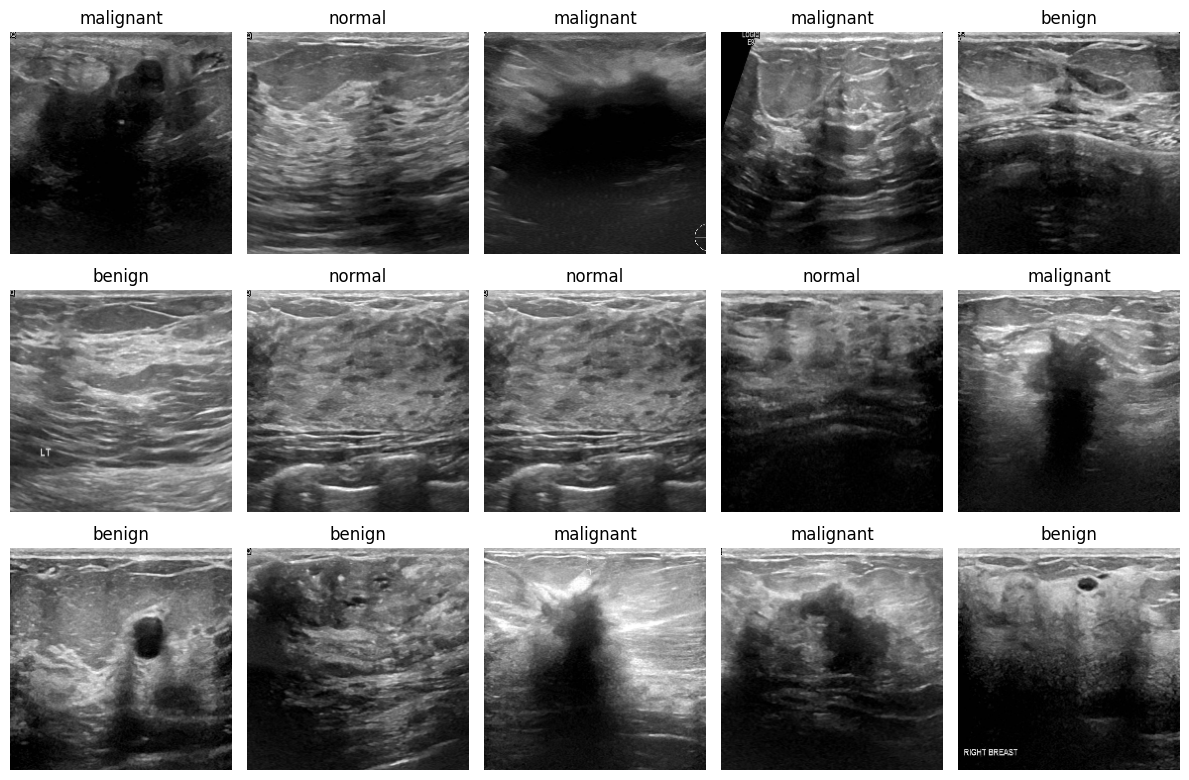

In [12]:
def display_sample_images(images, labels, class_names):
    plt.figure(figsize=(12, 8))
    for i in range(15):
        idx = random.randint(0, len(images) - 1)
        img = images[idx]
        label = labels[idx]

        plt.subplot(3, 5, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(class_names[label])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

images, labels = load_data(dataset_path)

display_sample_images(images, labels, class_names)

In [17]:
# Load data
X, y = load_data(dataset_path)

# Normalize the images
X = X / 255.0

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [18]:
# Function to create a model using a pretrained architecture
def create_pretrained_model(base_model_name):
    if base_model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    elif base_model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    elif base_model_name == 'MobileNetV2':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    elif base_model_name == 'DenseNet121':
        base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    else:
        raise ValueError("Base model not recognized.")

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    return model

In [19]:
# Function to compile and fit the model
def compile_and_fit_model(model):
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, batch_size=32,
                        validation_data=(X_test, y_test),
                        epochs=5)
    return history


In [20]:
# Create, compile and fit models with different pretrained architectures
model_names = ['VGG16', 'ResNet50', 'MobileNetV2','DenseNet121']

histories = []
model_weights = {}

for model_name in model_names:
    print(f"Training {model_name}...")
    model = create_pretrained_model(model_name)
    history = compile_and_fit_model(model)
    histories.append(history)
    model_weights[model_name] = model


Training VGG16...
Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 344ms/step - accuracy: 0.4168 - loss: 2.9843 - val_accuracy: 0.6603 - val_loss: 0.8593
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accuracy: 0.5422 - loss: 0.9504 - val_accuracy: 0.6667 - val_loss: 0.7739
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.6272 - loss: 0.8117 - val_accuracy: 0.6987 - val_loss: 0.7194
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - accuracy: 0.7002 - loss: 0.7049 - val_accuracy: 0.7372 - val_loss: 0.7236
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 198ms/step - accuracy: 0.6700 - loss: 0.6687 - val_accuracy: 0.6795 - val_loss: 0.7023
Training ResNet50...
Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 594ms/step - accuracy: 0.4412 - loss: 7.4361 - val_accuracy: 0.5769 - val_loss: 1.0574
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - accuracy: 0.5588 - loss: 1.0781 - val_accuracy: 0.5769 - val_loss: 1.0458
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.5461 

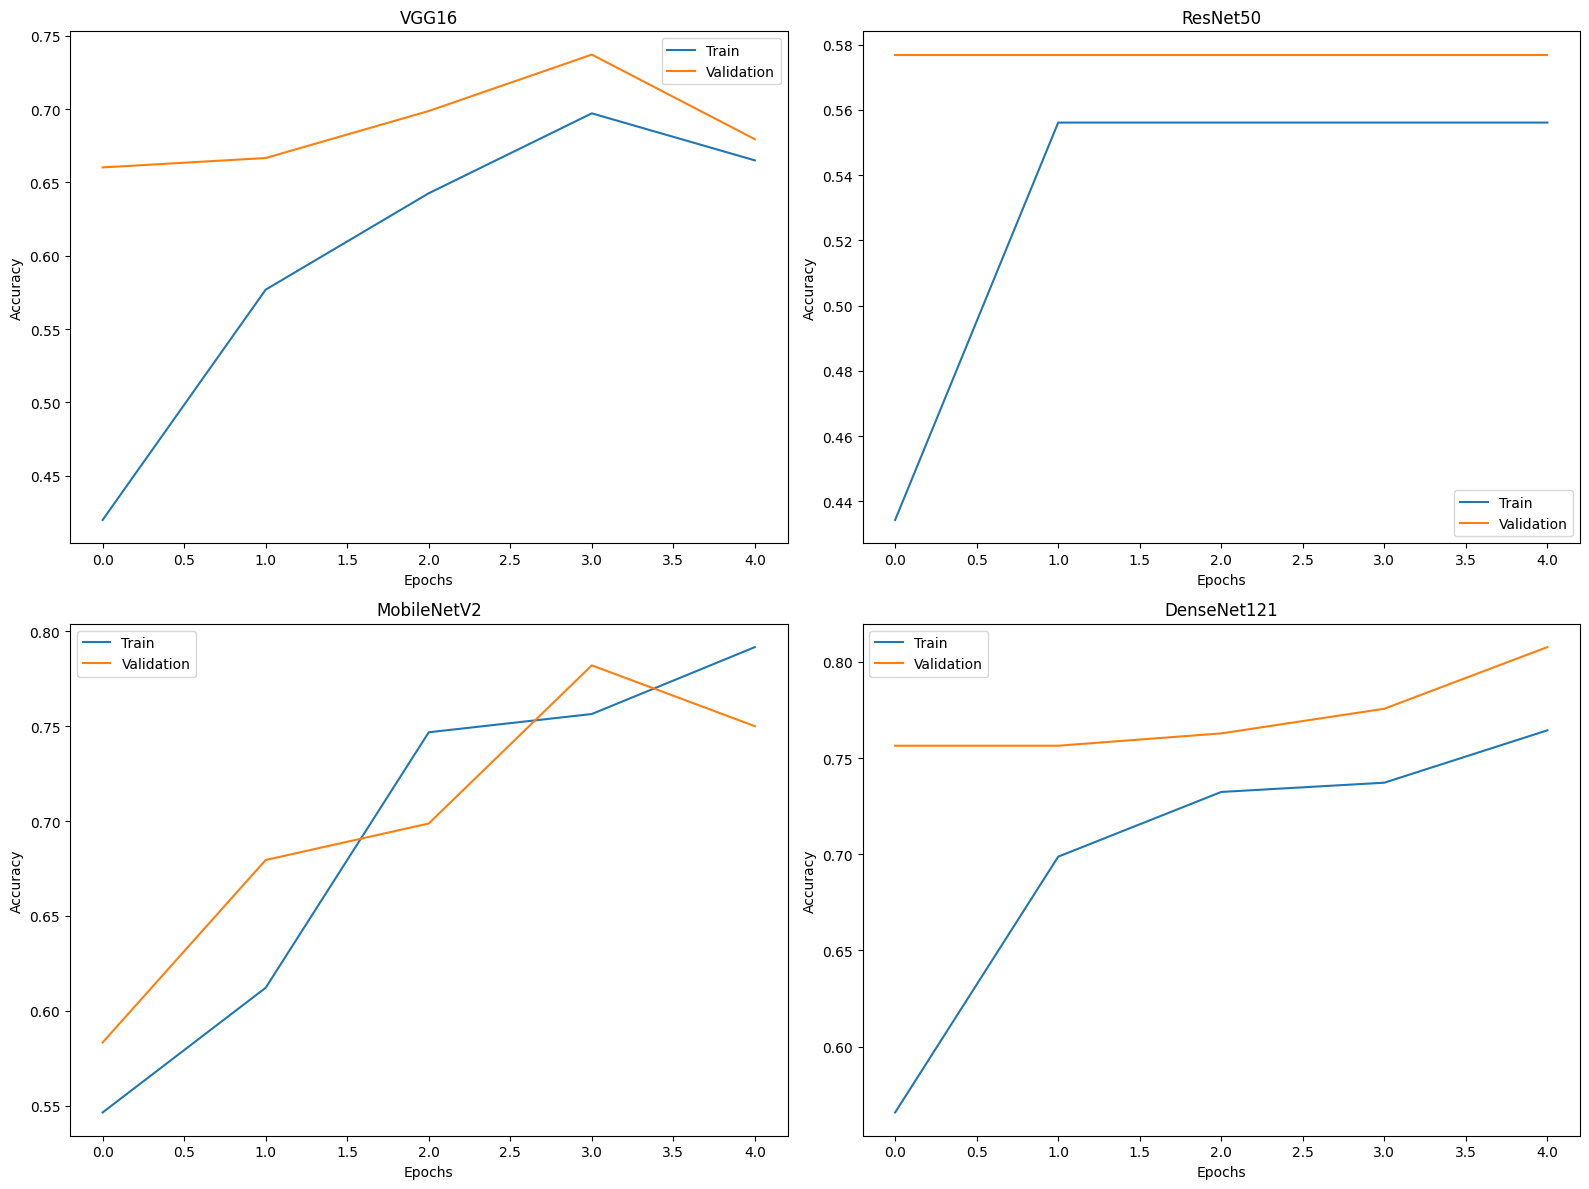

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Flatten the 2D array of axes to make looping easier
axs = axs.ravel()

# Loop over the models and plot the accuracy and validation accuracy
for i, history in enumerate(histories):
    axs[i].plot(history.history['accuracy'])
    axs[i].plot(history.history['val_accuracy'])
    axs[i].legend(['Train', 'Validation'])
    axs[i].set_xlabel('Epochs')
    axs[i].set_title(model_names[i])
    axs[i].set_ylabel('Accuracy')

plt.tight_layout()
plt.show()


In [22]:
for model_name in model_names:
  model = model_weights[model_name]
  model_loss, model_accuracy = model.evaluate(X_test,y_test)
  print(model_name,"\n")
  print(f"Model Loss : {model_loss}\nModel Accuracy : {model_accuracy}\n")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.6597 - loss: 0.7002
VGG16 

Model Loss : 0.7022627592086792
Model Accuracy : 0.6794871687889099

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.5686 - loss: 1.0003
ResNet50 

Model Loss : 0.9944542050361633
Model Accuracy : 0.5769230723381042

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7487 - loss: 0.9641
MobileNetV2 

Model Loss : 1.009601354598999
Model Accuracy : 0.75

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8100 - loss: 0.5776
DenseNet121 

Model Loss : 0.5932295918464661
Model Accuracy : 0.807692289352417



In [23]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import array_to_img

def output_plot(image, model, class_names):
    if len(image.shape) == 3:
        image = np.expand_dims(image, axis=0)

    predictions = model.predict(image)

    fig, axs = plt.subplots(1, 2, figsize=(10, 2))


    axs[0].imshow(array_to_img(image[0]))
    axs[0].axis('off')

    prediction_values = predictions[0]
    max_index = np.argmax(prediction_values)

    colors = ['green' if i == max_index else 'blue' for i in range(len(class_names))]

    axs[1].barh(class_names, prediction_values, color=colors)
    axs[1].set_xlim([0, 1])
    axs[1].set_title('Prediction Confidence')

    plt.tight_layout()
    plt.show()




Testing - VGG16 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


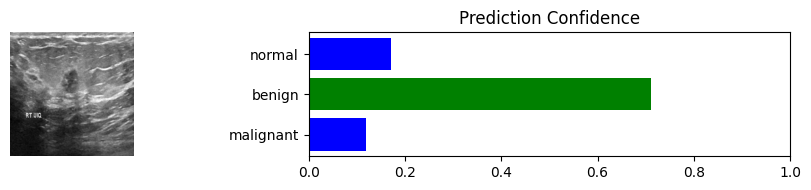



Testing - VGG16 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


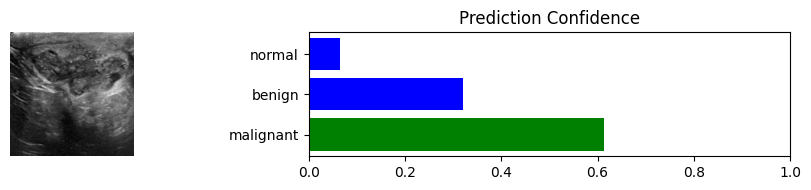



Testing - VGG16 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


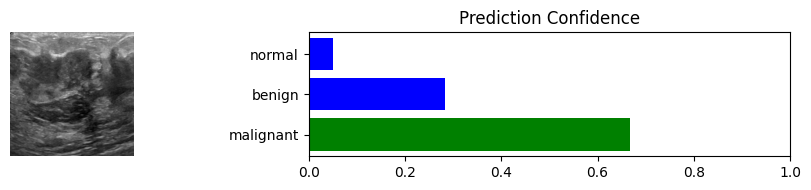



Testing - ResNet50 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


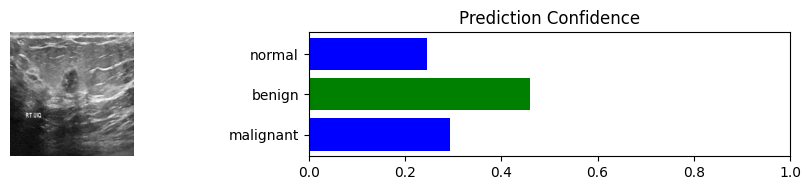



Testing - ResNet50 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


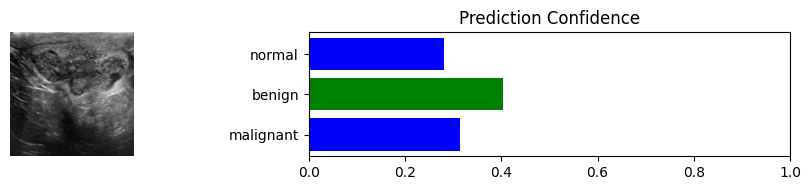



Testing - ResNet50 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


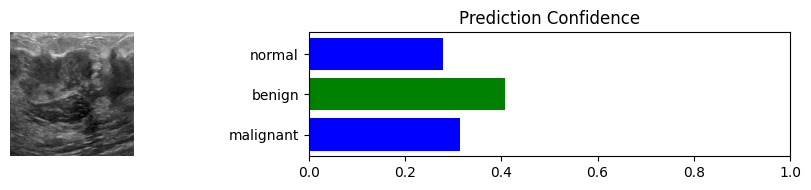



Testing - MobileNetV2 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


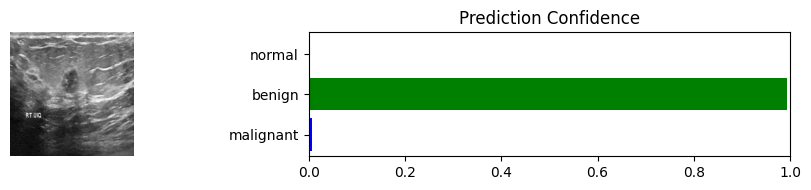



Testing - MobileNetV2 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


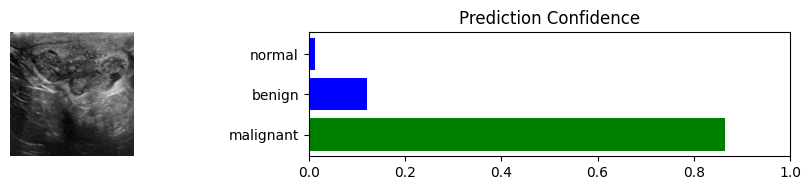



Testing - MobileNetV2 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


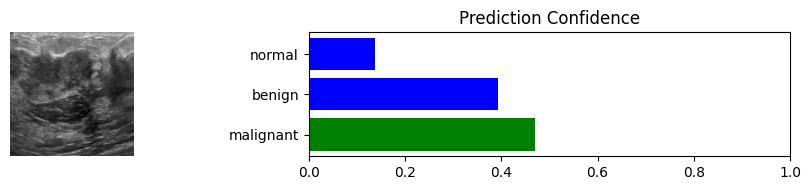



Testing - DenseNet121 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


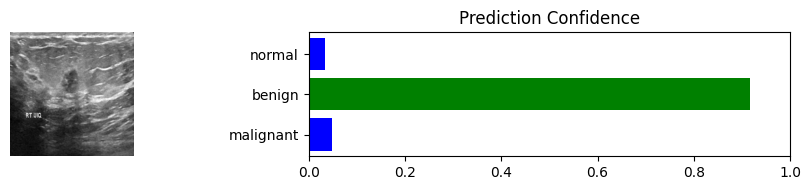



Testing - DenseNet121 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


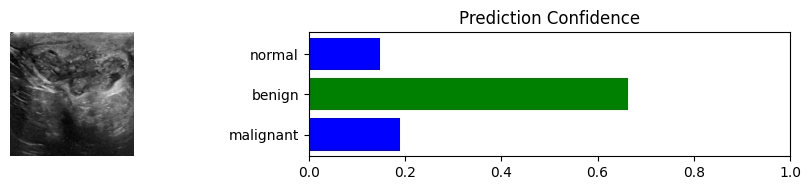



Testing - DenseNet121 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


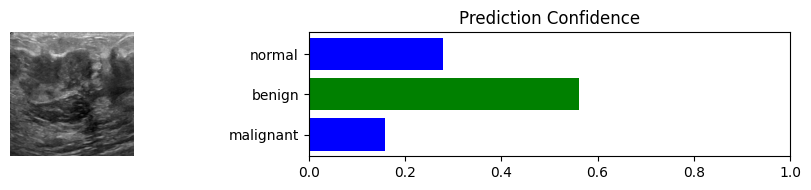

In [24]:
for model_name in model_names:
    for i in X_test[100:103]:
        print(f"\n\nTesting - {model_name} Model\n")
        output_plot(i, model_weights[model_name], class_names)